<a href="https://colab.research.google.com/github/Ishan1440/Survey-Response-Quality-Analysis/blob/main/ML_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
sample_filepath = "/content/drive/MyDrive/sampleResult.csv"

In [ ]:
result_df = pd.read_csv(sample_filepath)
result_df.head()

,Unique ID,Response Duration,Plag score,Superficial score,QA relevance,OE_Quality_Flag
0,3,10.0,0.1750,0.743633,1.106384,0
1,5,13.0,0.8875,0.110979,1.810645,0
2,6,10.0,0.6100,0.234869,0.897222,0
3,8,10.0,0.4150,0.195515,2.843587,0
4,10,12.0,0.7100,0.297127,2.905401,0


In [ ]:
result_df = result_df.iloc[ : , 1: ]
result_df.head()

,Response Duration,Plag score,Superficial score,QA relevance,OE_Quality_Flag
0,10.0,0.1750,0.743633,1.106384,0
1,13.0,0.8875,0.110979,1.810645,0
2,10.0,0.6100,0.234869,0.897222,0
3,10.0,0.4150,0.195515,2.843587,0
4,12.0,0.7100,0.297127,2.905401,0


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
RANDOM_STATE = 42

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
X = result_df.iloc[ : , :-1]
y = result_df.iloc[ : , -1]

In [ ]:
print("Original class distribution:", Counter(y))

Original class distribution: Counter({0: 2179, 1: 194})


In [ ]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

print("Training set class distribution:", Counter(y_train))
print("Test set class distribution:", Counter(y_test))

Training set class distribution: Counter({0: 1634, 1: 145})
Test set class distribution: Counter({0: 545, 1: 49})


In [ ]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Balanced training set class distribution:", Counter(y_train_balanced))

Balanced training set class distribution: Counter({0: 1634, 1: 1634})


Model 0 - Random Forest

In [ ]:
# from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [ ]:
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter search space
param_dist = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

# Create full pipeline with preprocessing and classifier
pipeline = Pipeline([
    # ('imputer', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [ ]:
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_balanced, y_train_balanced)

print("Best Hyperparameters:", random_search.best_params_)
print(f"Best Cross-validation accuracy: {random_search.best_score_:.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': None, 'classifier__bootstrap': False}
Best Cross-validation accuracy: 0.881


In [ ]:
# Predict on test set using best estimator from random search
y_pred = random_search.predict(X_test)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       545
           1       0.07      0.12      0.09        49

    accuracy                           0.80       594
   macro avg       0.50      0.49      0.49       594
weighted avg       0.85      0.80      0.82       594

Confusion Matrix:
 [[471  74]
 [ 43   6]]


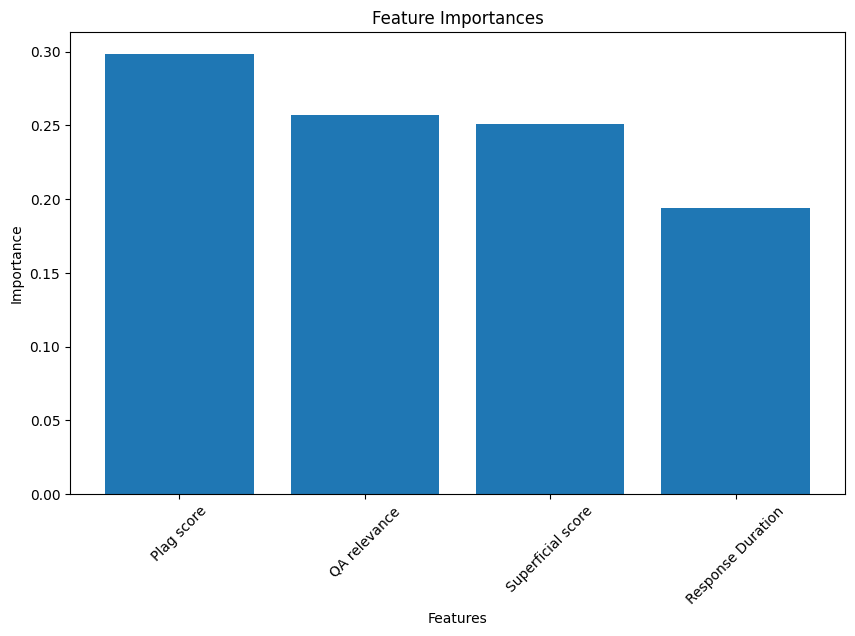

In [ ]:
import matplotlib.pyplot as plt

# Extract feature importances from the best model
best_rf_model = random_search.best_estimator_.named_steps['classifier']
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sorted_idx = importances.argsort()[::-1]
plt.bar(feature_names[sorted_idx], importances[sorted_idx])
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# import joblib

# # Save the best model to disk for future use
# joblib.dump(grid_search.best_estimator_, "best_xgb_model.pkl")

# # To load the model later:
# loaded_model = joblib.load("best_xgb_model.pkl")


In [ ]:
# best_rf_model.fit(X, y)

------------------

In [ ]:
numeric_features = ['Response Duration', 'Plag score', 'Superficial score', 'QA relevance']

scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Verify scaling
X.head()

,Response Duration,Plag score,Superficial score,QA relevance
0,-0.517490,-1.570165,2.026886,-0.470117
1,-0.186075,0.862109,-1.015066,0.236496
2,-0.517490,-0.085197,-0.419370,-0.679978
3,-0.517490,-0.750873,-0.608594,1.272886
4,-0.296546,0.256174,-0.120022,1.334907


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (1779, 4)
Test set size: (594, 4)


In [ ]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Balanced training set class distribution:", Counter(y_train_balanced))

Balanced training set class distribution: Counter({0: 1634, 1: 1634})


Model 2 - XGBoost

In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Define pipeline steps (scaling is already done separately above)
pipeline = XGBClassifier(random_state=42, use_label_encoder=False)

# Parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5],
}

In [ ]:
# Initialize XGBoost classifier with default parameters
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to training data
grid_search.fit(X_train_balanced, y_train_balanced)

# Print best parameters found by GridSearchCV
print("Best parameters found:", grid_search.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:47:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}


In [ ]:
# Predict on test set using best estimator from grid search
y_pred = grid_search.best_estimator_.predict(X_test)

# Classification report (precision/recall/f1-score)
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       545
           1       0.16      0.16      0.16        49

    accuracy                           0.86       594
   macro avg       0.54      0.54      0.54       594
weighted avg       0.86      0.86      0.86       594

Confusion Matrix:
[[502  43]
 [ 41   8]]


In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X, y)

In [ ]:
import joblib

# Save the best model to disk for future use
joblib.dump(grid_search.best_estimator_, "best_xgb_model.pkl")

# To load the model later:
loaded_model = joblib.load("best_xgb_model.pkl")
